In [1]:
import sys
import cv2
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
sys.path.append('mask_bracket')
import params

%matplotlib inline 

Using TensorFlow backend.


In [2]:
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1

def show_image(image, title=None):
    channels = image.shape[2] if len(image.shape) == 3 else 1
    if channels == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    oldfigsize = plt.rcParams["figure.figsize"]
    plt.rcParams["figure.figsize"] = (5,4)
    plt.autoscale(enable=True, axis='both', tight=False)
    plt.axis('off')
    plt.imshow(image, aspect='equal', interpolation='gaussian', cmap='gray' if channels == 1 else None)
    plt.show()
    plt.rcParams["figure.figsize"] = oldfigsize

Using our trained UNET model to highlight brackets. Wrapped it in highlight_brackets function

Train script is located at mask_bracket/train.py

In [3]:
model = params.model_factory()
model.load_weights('mask_bracket/baseline.h5')

In [4]:
def highlight_brackets(img):
  input_size = params.input_size
  orig_height, orig_width = img.shape
  img = cv2.resize(img, (input_size, input_size))
  img = np.array(img, np.float32) / 255
  preds = model.predict(img.reshape(1,input_size,input_size,1))
  preds = np.squeeze(preds, axis=3)
  pred = preds[0]
  pred = cv2.resize(pred, (orig_width, orig_height))
  res = (pred >= 0.5).astype(int)*255
  return res.astype("uint8")

In [5]:
path = "sample6.jpg"

In [6]:
original_image = cv2.imread(path)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
image = params.simplify_image(image)

Getting masks for brackets

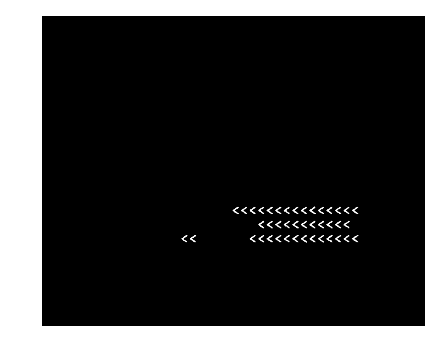

In [7]:
highlighted = highlight_brackets(image)
show_image(highlighted)

Then, it will be easy to find boundaries with cv2.findContours

In [8]:
def get_boundaries(imgray):
    _, contours, _  = cv2.findContours(imgray, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    boxes = []
    for cords in contours:
         cords = np.squeeze(cords)
         if len(cords.shape)>1:
             x = [a[0] for a in cords]
             y = [a[1] for a in cords]
             minx, maxx = np.min(x), np.max(x)
             miny, maxy = np.min(y), np.max(y)
             boxes.append((minx,miny,maxx,maxy))
    return boxes        
            
def draw_boundaries(image, boxes):
    fig,ax = plt.subplots(1)
    ax.imshow(image)
    for (minx,miny,maxx,maxy) in boxes:
         rect = Rectangle((minx-1,miny-3),maxx-minx+1,maxy-miny+3,linewidth=1,edgecolor='g',facecolor='none')
         ax.add_patch(rect)

Let's see the result for this step

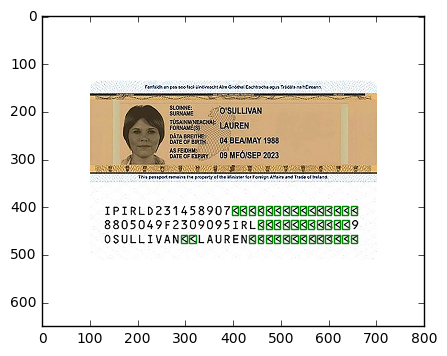

In [9]:
boxes = get_boundaries(highlighted)
draw_boundaries(original_image, boxes)

Converting image to united lines

In [10]:
def get_lines(img):
    gradX = cv2.morphologyEx(img, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_RECT, (40, 5)))
    return cv2.threshold(gradX, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]


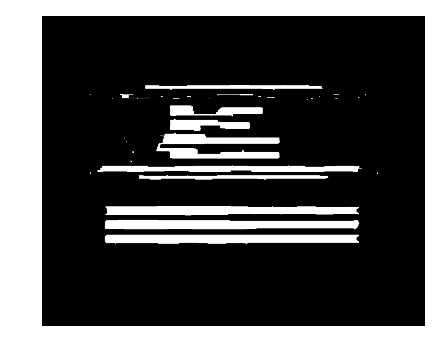

In [12]:
lines = get_lines(image)    
show_image(lines)

Finally searching for rows with brackets. 
Let's fine all rectangles, and ensure it contains at least one bracket

In [13]:
def get_bracket_lines(lines, boxes):
    
    def region_includes(region, box):
        #return region[0]<=box[0] and region[2]>=box[2] and region[1]<=box[1] and region[3]>=box[3]
        return region[1]<=box[1] and region[3]>=box[3]
    
    _, line_contours, _  = cv2.findContours(lines, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    brackets_lines = []
    for cords in line_contours:    
        cords = np.squeeze(cords)    
        if len(cords.shape) > 1:
            x = [a[0] for a in cords]
            y = [a[1] for a in cords]
            minx, maxx = np.min(x), np.max(x)
            miny, maxy = np.min(y), np.max(y)
            if (maxx - minx) > 100:
                region = (minx,miny,maxx,maxy)
                for box in boxes:
                    if region_includes(region, box):
                        brackets_lines.append(region)
                        break
    return brackets_lines                      
                    


Showing the final result

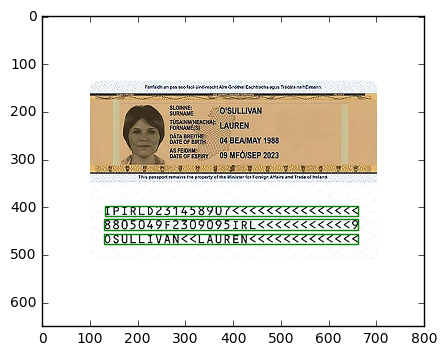

In [14]:
brackets_lines = get_bracket_lines(lines, boxes)                    
draw_boundaries(original_image, brackets_lines)

### Let's test on something else...

In [15]:
def draw_mrz_lines(path):
    original_image = cv2.imread(path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
    image = params.simplify_image(image)
    highlighted = highlight_brackets(image)    
    boxes = get_boundaries(highlighted)
    lines = get_lines(image)
    brackets_lines = get_bracket_lines(lines, boxes)
    draw_boundaries(original_image, brackets_lines)

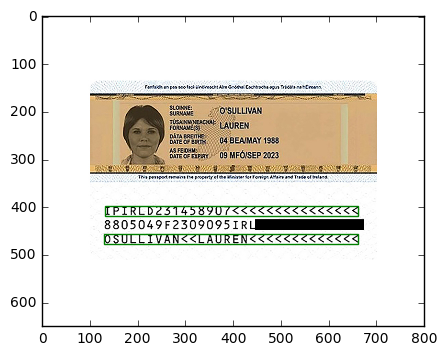

In [16]:
draw_mrz_lines("sample62lines.png")

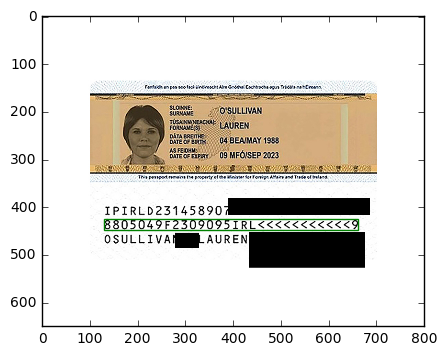

In [17]:
draw_mrz_lines("sample6oneline.png")

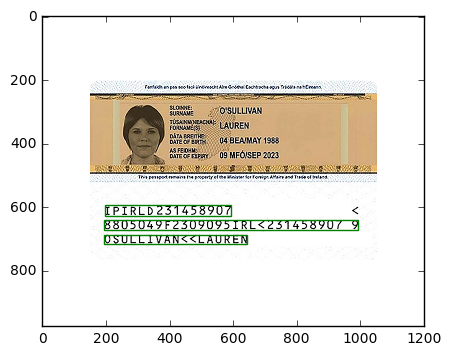

In [18]:
draw_mrz_lines("sample6fewbrackets.png")

## Let's try another passport

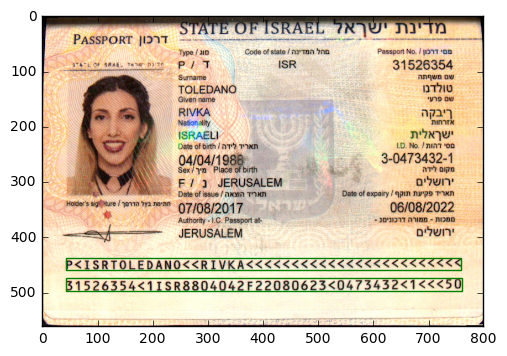

In [19]:
draw_mrz_lines("israel.jpg")

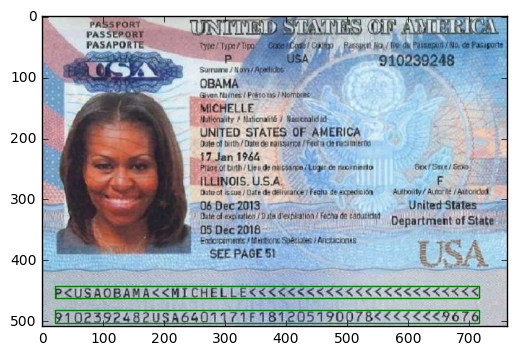

In [20]:
draw_mrz_lines("usa.jpg")